## TRANSFER LEARNING: IMPROVING ALGORITHM
---

### Libraries

In [42]:
import pickle
import os

#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#tensorflow and keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomCrop, RandomFlip, RandomRotation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from keras.utils import load_img, img_to_array

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#open cv
import cv2 as cv


from cascid.configs import config, pad_ufes
from cascid import database

### Constants

In [44]:
# PATH = "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/data/"
RANDOM_STATE = 42
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
TEST_SIZE = 0.15
EPOCHS = 250
IMAGE_SHAPE = (128, 128, 3)

FERNANDO_PATH = config.DATA_DIR / 'experiments' / 'fernando'
FERNANDO_PATH.mkdir(exist_ok=True, parents=True)

IMAGE_CACHE = FERNANDO_PATH / 'img_cache.pkl'
FEATURES_FILE = FERNANDO_PATH / 'features.pkl'

READ_FULL_DATAFRAME = True
COMPUTE_FEATURES = True


### Loading data

In [35]:
df = database.get_db()
df.head(5).transpose()

,0,1,2,3,4
patient_id,PAT_1516,PAT_46,PAT_1545,PAT_1989,PAT_684
lesion_id,1765,881,1867,4061,1302
smoke,NaN,False,NaN,NaN,False
drink,NaN,False,NaN,NaN,True
background_father,NaN,POMERANIA,NaN,NaN,POMERANIA
background_mother,NaN,POMERANIA,NaN,NaN,POMERANIA
age,8,55,77,75,79
pesticide,NaN,False,NaN,NaN,False
gender,NaN,FEMALE,NaN,NaN,MALE
skin_cancer_history,NaN,True,NaN,NaN,True


### Split train, validation and test

In [36]:
MulticlassEncoder = OneHotEncoder(sparse=False)
Y = MulticlassEncoder.fit_transform(df[["diagnostic"]].to_numpy())
x_train, x_test, y_train, y_test = train_test_split(df["img_id"].to_numpy(), Y, test_size=0.2, random_state=RANDOM_STATE)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

print("x_train shape: {0}".format(x_train.shape))
print("x_validation shape: {0}".format(x_valid.shape))
print("x_test shape: {0}".format(x_test.shape))

print("y_train shape: {0}".format(y_train.shape))
print("y_validation shape: {0}".format(y_valid.shape))
print("y_test shape: {0}".format(y_test.shape))

x_train shape: (1470,)
x_validation shape: (368,)
x_test shape: (460,)
y_train shape: (1470, 6)
y_validation shape: (368, 6)
y_test shape: (460, 6)


### Image Test

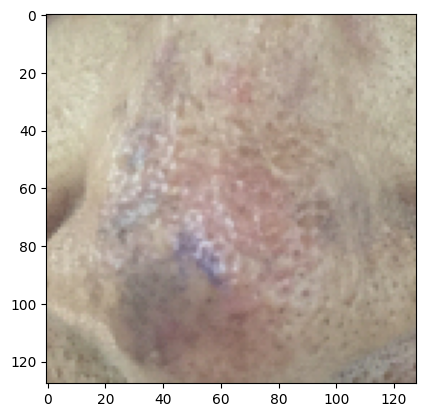

In [45]:
def load_image(name: str):
    pil_img = load_img(
        str(pad_ufes.IMAGES_DIR / name),
        grayscale=False,
        color_mode='rgb',
        target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
        interpolation='nearest',
        keep_aspect_ratio=False
    )

    return img_to_array(pil_img, dtype=np.uint8)

plt.imshow(load_image(x_train[7]))
plt.show()

### Image Loading and cache

In [46]:
# Automatic caching of image read operations (slow)
if not os.path.exists(IMAGE_CACHE):
    print("Cache not found, doing read operations...")
    reader = lambda img_path_list : np.array(list(map(load_image, img_path_list)))
    image_dict = {
        "train": reader(x_train),
        "test": reader(x_test),
        "valid": reader(x_valid)
    }
    with open(IMAGE_CACHE, 'wb') as file:
        pickle.dump(image_dict, file)
    print("Read operation done, cache file available at {}".format(IMAGE_CACHE))
else:
    with open(IMAGE_CACHE, 'rb') as file:
        image_dict = pickle.load(file)

# Return to original variables
x_train = image_dict["train"]
x_test = image_dict["test"]
x_valid = image_dict["valid"]

### Data augmentation

In [38]:
# train_data_augmentation_generator = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
# )

input_layer = keras.Sequential([
    Rescaling(1./255), # Rescale from 0 to 255 UINT8 to 0 to 1 float.
])

augmentor = keras.Sequential([
    RandomBrightness(factor=(-0.3, 0.3), value_range=(0.0, 1.0), seed=RANDOM_STATE), # Randomly change brightness anywhere from -30% to +30%
    RandomContrast(factor=0.5, seed=RANDOM_STATE), # Randomly change contrast anywhere from -30% to +30%
    RandomFlip(mode="horizontal_and_vertical", seed=RANDOM_STATE), # Randomly flip images either horizontally, vertically or both
    RandomRotation(factor=(-0.3, 0.3), fill_mode="nearest", interpolation="bilinear", seed=RANDOM_STATE), # Randomly rotate anywhere from -30% * 2PI to +30% * 2PI, filling gaps by using 'nearest' strategy
])

In [39]:
imgs = np.array(list(map(load_image, x_train[:5]))) # Load small sub-sample to test workflow
imgs.shape

(5, 128, 128, 3)

In [40]:
rescaled = input_layer(imgs)
augmented = augmentor(rescaled)

### Model

In [41]:
if COMPUTE_FEATURES:
    resnet = keras.applications.ResNet50(
        weights='imagenet',
        input_shape=IMAGE_SHAPE,
        pooling='avg',
        include_top=False,
    )
    resnet.trainable = False  #to make sure it's not being trained
    # Augmentation only on training
    feature_extractor_train = keras.Sequential([
        input_layer,
        augmentor,
        resnet
    ])
    # Test/Validation only get rescaled
    feature_extractor_test_valid = keras.Sequential([
        input_layer,
        resnet
    ])
    features_train = feature_extractor_train(x_train[:5])
    features_valid = feature_extractor_test_valid(x_valid[:5])
    features_test = feature_extractor_test_valid(x_test[:5])

    features = {
        "train": features_train.numpy(),
        "test": features_test.numpy(),
        "valid": features_valid.numpy()
    }

    with open(FEATURES_FILE, 'wb') as file:
        pickle.dump(features, file)
else:
    with open(FEATURES_FILE, 'rb') as file:
        features = pickle.load(file)

2022-09-14 14:20:04.323332: W tensorflow/core/framework/op_kernel.cc:1757] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to uint8 is not supported


UnimplementedError: Exception encountered when calling layer "sequential_6" "                 f"(type Sequential).

{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to uint8 is not supported [Op:Cast]

Call arguments received by layer "sequential_6" "                 f"(type Sequential):
  • inputs=tf.Tensor(shape=(5,), dtype=string)
  • training=False
  • mask=None

In [ ]:
features.shape

In [ ]:
input_layer = Input(shape=(2048, ))
output_layer = Dense(6, activation='softmax')(input_layer)
model = Model(input_layer, output_layer)

In [ ]:
# feature_extractor.trainable = False #to make sure it's not being trained
# input_layer = Input(shape=IMAGE_SHAPE)
# pre_treined_model = feature_extractor(input_layer, training=False) #add input layer
# pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
# output_layer = Dense(6, activation='softmax')(pre_treined_model_with_polling)
# model = Model(input_layer, output_layer)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

### Train

In [ ]:
best_model_checkpoint_early_stopping = EarlyStopping(monitor='val_accuracy',
                                                     mode='max',
                                                     verbose=1,
                                                     patience=100,
                                                     restore_best_weights=True)

best_model_checkpoint = ModelCheckpoint(
    filepath=
    "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test02/model",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True)


In [ ]:
# training_history = model.fit(
#     x = train_data_augmentation_generator.flow(
#         x_train_to_array,
#         y_train_to_array),
#     epochs = EPOCHS,
#     validation_data = (x_valid_to_array, y_valid_to_array),
#     batch_size=8,
#     callbacks=[best_model_checkpoint, best_model_checkpoint_early_stopping]
# )

In [ ]:
training_history = model.fit(
    features,
    y_train_to_array,
    epochs=EPOCHS,
    validation_split=0.2,
    batch_size=256,
    #callbacks=[best_model_checkpoint, best_model_checkpoint_early_stopping]
)

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(y=training_history.history['val_accuracy'],
               mode='lines',
               name='Acc - Validation'))
fig.add_trace(
    go.Scatter(y=training_history.history['accuracy'],
               mode='lines',
               name='Acc - Training'))


In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(y=training_history.history['val_loss'],
               mode='lines',
               name='Validation loss'))
fig.add_trace(
    go.Scatter(y=training_history.history['loss'],
               mode='lines',
               name='Training loss'))


### Evaluating the model

In [ ]:
loss, acc = model.evaluate(x=x_test_to_array, y=y_test_to_array)
print("model loss: {0}".format(loss))
print("model accuracy: {0}".format(acc))

In [ ]:
predictions = model.predict(x_test_to_array)

In [ ]:
classe_names = y_train.unique().tolist()
classe_names

In [ ]:
predictions_categorical = list()
for list_ar in predictions:
    predictions_categorical.append(classe_names[np.argmax(list_ar)])

In [ ]:
y_test.value_counts(True)

In [ ]:
pd.Series(predictions_categorical).value_counts(True)